<a href="https://colab.research.google.com/github/joomm/CNN/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

압축파일풀기

In [ ]:
%cd /content/drive/MyDrive/cnn/root/dataset/11/정상

!unzip -qq "/content/drive/MyDrive/cnn/root/dataset/11/11.토마토_0.정상.zip"

/content/drive/MyDrive/cnn/root/dataset/11/정상


---

---







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
# 모듈 저장
with open('config.py', 'w') as file:
    file.write("""
class config():
    path_prefix = '/content/drive/MyDrive/cnn/root'
    path_data = 'dataset'

    dict_label = {'11': {'00':0, '18': 1, '19': 2}}

    # general args
    gpu = 0
    train_size = (512, 512)
    train_model = 'resnet50' #'ENet'
    pnum = 77
    crop_name = '11'
    num_classes = 3

    # Training args
    train_data_dir = f'{path_prefix}/{path_data}/{crop_name}/test'
    batch_size = 32
    num_workers = 2
    learning_rate = 0.001
    num_epochs = 2

    # testing args
    # test_model_path = '/content/drive/MyDrive/cnn/root/weights/sample.pt'
""")

# config 모듈이 현재 sys.modules에 있는지 확인
if 'config' in sys.modules:
    # 모듈이 로드되어 있다면 모듈을 다시 로드
    import importlib
    import config
    importlib.reload(config)

    # config 모듈 내용 확인
    print(config.__dict__)

else:
    # 모듈이 로드되어 있지 않다면 import 문을 통해 로드
    import config

In [3]:
import sys
# 모듈 저장
with open('transforms.py', 'w') as file:
    file.write("""
import albumentations

from config import config as cfg

train_aug = albumentations.Compose([albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225],
                                                             max_pixel_value=255.0,
                                                             p=1.0)
                                   ],
                                   p=1.0)
""")
# config 모듈이 현재 sys.modules에 있는지 확인
if 'transforms' in sys.modules:
    # 모듈이 로드되어 있다면 모듈을 다시 로드
    import importlib
    import transforms
    importlib.reload(transforms)

    # config 모듈 내용 확인
    print(transforms.__dict__)

else:
    # 모듈이 로드되어 있지 않다면 import 문을 통해 로드
    import transforms

In [4]:
import sys
# 모듈 저장
with open('models.py', 'w') as file:
    file.write("""
import torch.nn as nn
import torchvision.models as models

dict_backbone = {'resnet50' : models.resnet50}

def get_model(model_name='resnet50', num_classes=3, pretrained=True): # use pretrained backbone
    assert model_name in {'resnet50'}

    # 미리 훈련된 가중치를 사용하여 ResNet 모델을 로드합니다.
    network = models.resnet50(pretrained=pretrained)

    # 모델의 모든 레이어를 순회하면서 마지막 레이어를 찾습니다.
    for name, layer in network.named_children():
        if name == 'fc':
            # 'fc' 레이어를 찾으면 수정합니다.
            setattr(network, name, nn.Linear(layer.in_features, num_classes))
            break
        elif isinstance(layer, nn.Linear):
            # 레이어가 'fc' 레이어가 아니지만 Linear 레이어인 경우 수정합니다.
            setattr(network, name, nn.Linear(layer.in_features, num_classes))
            break

    return network
""")
# config 모듈이 현재 sys.modules에 있는지 확인
if 'models' in sys.modules:
    # 모듈이 로드되어 있다면 모듈을 다시 로드
    import importlib
    import models
    importlib.reload(models)

    # config 모듈 내용 확인
    print(models.__dict__)

else:
    # 모듈이 로드되어 있지 않다면 import 문을 통해 로드
    import models

In [5]:
import sys
# 모듈 저장
with open('utils.py', 'w') as file:
    file.write("""
import os
import numpy as np
import datetime

import torch

def make_data(path, phase='test'):
    path_images = []

    for img_name in os.listdir(f'{path}/{phase}'):
        if img_name.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
            path_images.append(f'{path}/{phase}/{img_name}')

    return np.stack(path_images)

def cnt_correct(y_true, y_pred):
    top_N, top_class = y_pred.topk(1, dim=-1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.sum(equals.type(torch.FloatTensor)).item()

def log_with_timestamp(msg):
    print(f'{datetime.datetime.today()} : {msg}')

def bash_cmd(cmd):
    print()
    _ = os.system(cmd)
    print()
""")
# config 모듈이 현재 sys.modules에 있는지 확인
if 'utils' in sys.modules:
    # 모듈이 로드되어 있다면 모듈을 다시 로드
    import importlib
    import utils
    importlib.reload(utils)

    # config 모듈 내용 확인
    print(utils.__dict__)

else:
    # 모듈이 로드되어 있지 않다면 import 문을 통해 로드
    import utils

In [6]:
import sys
# 모듈 저장
with open('datasets.py', 'w') as file:
    file.write("""
import cv2
import numpy as np
import json

import torch
from torch.utils.data import Dataset

import transforms
from config import config as cfg

class CustomDataSet(Dataset):
    def __init__(self, path_images, transform, test=False):
        self.path_images = path_images
        self.transform = transform
        self.test = test

    def __getitem__(self, index):
        image = cv2.imread(self.path_images[index])[:,:,::-1]

        with open(f'{self.path_images[index]}.json') as json_file:
            json_decoded = json.load(json_file)
        label = cfg.dict_label[f'{int(json_decoded["annotations"]["crop"]):02d}'][f'{int(json_decoded["annotations"]["disease"]):02d}']

        resized_image = cv2.resize(image, cfg.train_size, interpolation = cv2.INTER_LANCZOS4) # INTER_AREA
        augmented_image = self.transform(image=resized_image)['image']

        if not self.test:
            return torch.tensor(augmented_image.transpose(2,0,1)), torch.tensor(label).long()
        else:
            return torch.tensor(augmented_image.transpose(2,0,1)), torch.tensor(label).long(), self.path_images[index]

    def __len__(self):
        return len(self.path_images)
""")
# config 모듈이 현재 sys.modules에 있는지 확인
if 'datasets' in sys.modules:
    # 모듈이 로드되어 있다면 모듈을 다시 로드
    import importlib
    import datasets
    importlib.reload(datasets)

    # config 모듈 내용 확인
    print(datasets.__dict__)

else:
    # 모듈이 로드되어 있지 않다면 import 문을 통해 로드
    import datasets

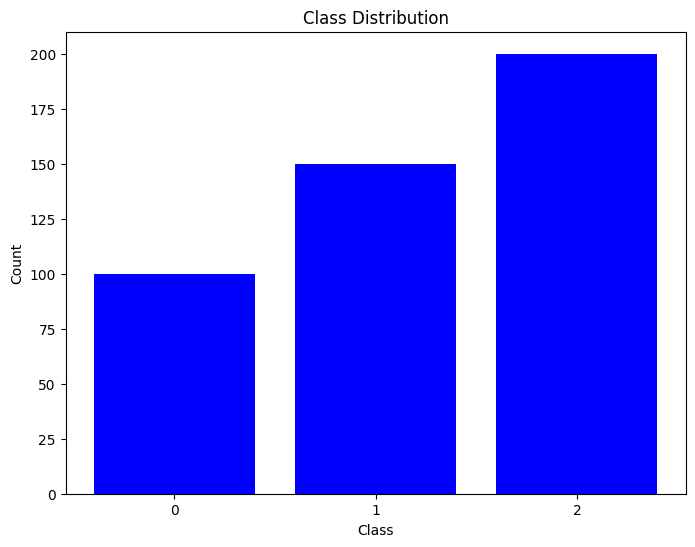

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# 예제 데이터셋 (실제 데이터셋에 맞게 수정해야 함)
data = {
    'Class': [0, 1, 2],
    'Count': [100, 150, 200]  # 각 클래스에 대한 데이터 개수
}

df = pd.DataFrame(data)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(df['Class'], df['Count'], color='blue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(df['Class'])
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os
import matplotlib.pyplot as plt

from datasets import CustomDataSet
import transforms
import utils
from config import config as cfg
from models import get_model

def train(model, train_loader, optimizer, criterion):
    model.train()

    train_losses = []  # 학습 중에 Loss 값을 기록할 리스트

    for epoch in range(cfg.num_epochs):
        print(f'Epoch {epoch + 1}/{cfg.num_epochs} ...')

        for i, (image, label) in enumerate(train_loader):
            is_cuda = torch.cuda.is_available()

            # 최적화기 초기화
            optimizer.zero_grad()

            # 순전파 및 손실 계산
            pred = model(image)
            loss = criterion(pred, label)

            # 역전파
            loss.backward()

            # 가중치 업데이트
            optimizer.step()

            train_losses.append(loss.item())  # Loss 값을 기록

            if (i + 1) % 10 == 0:
                print(f'Train Batch {i + 1}/{len(train_loader)} - Loss: {loss.item()}')

    print('Training finished.')

    # Loss 값을 그래프로 플로팅
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

def main():
    # 데이터 로딩
    path_images_train = utils.make_data(f'{cfg.path_prefix}/{cfg.path_data}/{cfg.crop_name}', 'test')
    #path_images_test = utils.make_data(f'{cfg.path_prefix}/{cfg.path_data}/{cfg.crop_name}', 'test')

    # 데이터셋 및 데이터로더 생성
    train_dataset = CustomDataSet(path_images_train, transforms.train_aug, test=False)
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)

    #test_dataset = CustomDataSet(path_images_train, transforms.test_aug, test=True)
    #test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    # 모델 생성 및 옵티마이저, 손실 함수 정의
    model = get_model(model_name=cfg.train_model, num_classes=cfg.num_classes, pretrained=True)

    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    criterion = nn.CrossEntropyLoss()

    # 학습
    train(model, train_loader, optimizer, criterion)

    # 테스트
    #test_loss, test_acc, list_true, list_pred = test(model, test_loader, criterion)

    print('\n===== Test result =====\n')
    print(classification_report(list_true, list_pred, digits=5))
    print('\n========= Confusion Matrix =========\n')
    print(confusion_matrix(list_true, list_pred))

    print('\nLog csv ... ')
    df = pd.DataFrame({'image_name': path_images_test,
                       'true': list_true,
                       'pred': list_pred})

    df.to_csv(f'{cfg.pnum}_{cfg.crop_name}_log_each_sample.csv')

    print('\n===== Finished testing =====')

if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/2 ...


In [ ]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd

import torch
from torch.utils.data import DataLoader

import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel

import transforms
import datasets
import utils
from models import get_model
from config import config as cfg

from sklearn.metrics import confusion_matrix, classification_report

pnum = cfg.pnum
crop_name = cfg.crop_name

is_cuda = torch.cuda.is_available()

os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.gpu)

path_images_test = utils.make_data(f'{cfg.path_prefix}/{cfg.path_data}/{cfg.crop_name}', '3')

def test(model, valid_loader, criterion):
    model.eval()

    list_true = []
    list_pred = []

    loss_sum = 0
    correct_sum = 0

    log_every = len(valid_loader)//5

    len_data = 0

    utils.log_with_timestamp(f'Test ... 0%')

    for i, (image, label, name) in enumerate(valid_loader):
        if is_cuda and cfg.gpu is not None:
            image = image.cuda(cfg.gpu, non_blocking=True)
            label = label.cuda(cfg.gpu, non_blocking=True)

        pred = model(image)

        loss = criterion(pred, label)
        loss_sum += loss.item()

        len_data += image.shape[0]
        correct_sum += utils.cnt_correct(label, pred)

        list_true.append(label.detach().cpu().numpy().flatten())
        list_pred.append(pred.detach().cpu().numpy().argmax(-1).flatten())

        if (i+1)%log_every == 0:
            utils.log_with_timestamp(f'Test ... {((i+1)//log_every)*20}%')

    return loss_sum/len_data, correct_sum/len_data, np.concatenate(list_true, axis=0), np.concatenate(list_pred, axis=0)


def main():
    print('========= Test Environment =========\n')
    _ = utils.bash_cmd('cat /proc/cpuinfo | grep "model name" | uniq')
    _ = utils.bash_cmd('nvidia-smi')
    _ = utils.bash_cmd('free -h')
    _ = utils.bash_cmd('df /')
    _ = utils.bash_cmd('cat /etc/os-release')

    print('\nPyTorch version: ', torch.__version__, '\n')

    utils.log_with_timestamp('Model loading ... ')
    model = get_model(cfg.train_model, cfg.num_classes)
    ckpt = torch.load(cfg.test_model_path, map_location='cpu')
    model.load_state_dict(ckpt['model_state_dict'])

    utils.log_with_timestamp('Model compiling ... ')
    criterion = torch.nn.CrossEntropyLoss()

    if cfg.gpu is not None and is_cuda:
        utils.log_with_timestamp(f"Use GPU: {cfg.gpu} for testing")
        torch.cuda.set_device(cfg.gpu)
        model = model.cuda(cfg.gpu)
    else:
        utils.log_with_timestamp('Use CPU, this will be slow')

    test_loader = DataLoader(datasets.CustomDataSet(path_images_test, transforms.test_aug, test=True), batch_size=1, shuffle=False, num_workers=0)

    print('\n===== Start testing =====\n')
    test_loss, test_acc, list_true, list_pred = test(model, test_loader, criterion)

    print('\n===== Test result =====\n')
    print(classification_report(list_true, list_pred, digits=5))
    print('\n========= Confusion Matrix =========\n')
    for rr in confusion_matrix(list_true, list_pred):
        print(rr)

    print('\nLog csv ... ')
    df = pd.DataFrame({'image_name': path_images_test,
                       'true': list_true,
                       'pred': list_pred})

    df.to_csv(f'{pnum}_{crop_name}_log_each_sample.csv')

    print('\n===== Finished testing =====')

    _ = utils.bash_cmd('sh rm_cache.sh')

if __name__ == '__main__':
    main()

========= Test Environment =========












PyTorch version:  2.1.0+cu118 

2023-12-06 16:35:48.623672 : Model loading ... 


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


2023-12-06 16:35:54.224267 : Model compiling ... 
2023-12-06 16:35:54.224999 : Use GPU: 0 for testing

===== Start testing =====

2023-12-06 16:35:54.267776 : Test ... 0%
2023-12-06 16:41:30.216492 : Test ... 20%
2023-12-06 16:46:46.098710 : Test ... 40%
2023-12-06 16:52:06.024025 : Test ... 60%
2023-12-06 16:57:36.814354 : Test ... 80%
2023-12-06 17:02:55.179908 : Test ... 100%

===== Test result =====

              precision    recall  f1-score   support

           0    1.00000   0.19986   0.33314      4423
           1    0.00000   0.00000   0.00000         0
           2    0.00000   0.00000   0.00000         0

    accuracy                        0.19986      4423
   macro avg    0.33333   0.06662   0.11105      4423
weighted avg    1.00000   0.19986   0.33314      4423


========= Confusion Matrix =========

[ 884 1198 2341]
[0 0 0]
[0 0 0]

Log csv ... 

===== Finished testing =====




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
